In [1]:
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt


In [ ]:
class Flow(nn.Module):
    def __init__(self, dim: int = 1, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return x_t + (t_end - t_start) * self(
            t=t_start + (t_end - t_start) / 2,
            x_t=x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2
        )


# Distribution

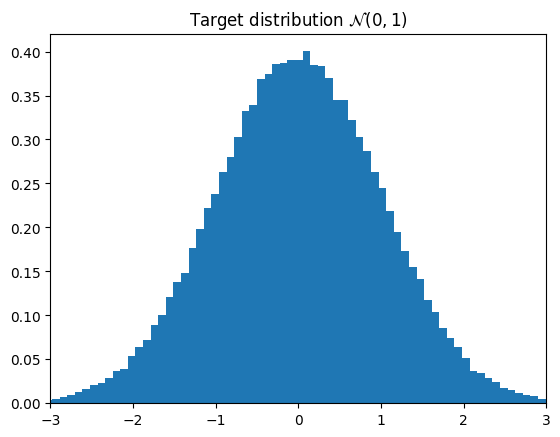

In [42]:
samples = torch.randn(100000, 1)
plt.hist(samples.numpy(), bins=100, density=True)
plt.title("Target distribution $\mathcal{N}(0, 1)$")
plt.xlim(-3, 3)
plt.show()


# Training

In [32]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = torch.randn(256, 1)
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)

    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()


# Sampling

Number of extreme samples: 1275
torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])


/tmp/ipykernel_2448406/1741605480.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_start = torch.tensor(time_steps[i],  device=x.device)
/tmp/ipykernel_2448406/1741605480.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_end   = torch.tensor(time_steps[i+1], device=x.device)


torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])
torch.Size([1275, 1])
torch.Size([])


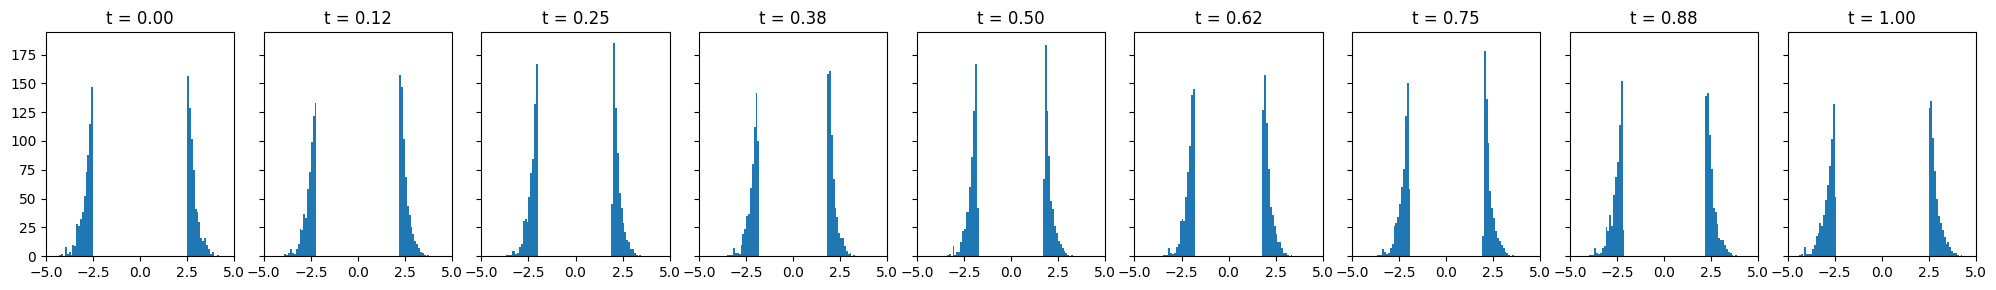

In [40]:
import torch
import matplotlib.pyplot as plt

x = torch.randn(100000, 1)
sigma = 1
x = x * sigma

# Only keep values in the extreme tails
threshold = 2.5 * sigma  # can use 2, 2.5, 3, etc.
tail_mask = (x < -threshold) | (x > threshold)
x = x[tail_mask]

x = x.view(-1, 1)

print(f"Number of extreme samples: {x.shape[0]}")

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(20, 3), sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].hist(x.detach().numpy(), bins=100, range=(-5, 5))
axes[0].set_title(f"t = {time_steps[0]:.2f}")
axes[0].set_xlim(-5.0, 5.0)

for i in range(n_steps):
    t_start = torch.tensor(time_steps[i],  device=x.device)
    t_end   = torch.tensor(time_steps[i+1], device=x.device)

    x = flow.step(x_t=x, t_start=t_start, t_end=t_end)
    axes[i + 1].hist(x.detach().numpy(), bins=100, range=(-5, 5))
    axes[i + 1].set_title(f"t = {time_steps[i + 1]:.2f}")
    axes[i + 1].set_xlim(-5.0, 5.0)

plt.tight_layout()
plt.show()


In [35]:
x.shape

torch.Size([1322])

In [37]:
x = torch.randn(100000, 1).shape